In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
import os
print("LD_LIBRARY_PATH:", os.environ.get('LD_LIBRARY_PATH'))


LD_LIBRARY_PATH: /usr/local/cuda/lib64:


In [3]:
import tensorflow as tf
print("GPUs detected:", tf.config.list_physical_devices('GPU'))


2025-06-06 03:39:42.162288: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 03:39:42.171755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749199182.182058    2338 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749199182.185082    2338 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749199182.193480    2338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models #type: ignore
from tensorflow.keras.applications import ResNet50  #type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator #type: ignore
from tensorflow.keras.utils import to_categorical #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.optimizers.schedules import ExponentialDecay #type: ignore
from tensorflow.keras.regularizers import l2 #type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #type: ignore
from tensorflow.keras.metrics import AUC, Precision, Recall #type: ignore

In [ ]:
class ImageDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.images = []
        self.labels = []
        self.class_names = ['no_plaga', 'plaga'] 
        
    def load_data(self):
        """Carga datos con validación mejorada"""
        total_images = 0
        class_counts = {}
        
        for idx, label in enumerate(self.class_names):
            label_dir = os.path.join(self.data_dir, label)
            if not os.path.exists(label_dir):
                print(f"⚠️  Advertencia: no existe la carpeta {label_dir}")
                continue
                
            class_count = 0
            for image_name in os.listdir(label_dir):
                if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    continue
                    
                img_path = os.path.join(label_dir, image_name)
                img_array = self.load_and_preprocess_image(img_path)
                if img_array is not None:
                    self.images.append(img_array)
                    self.labels.append(idx) 
                    class_count += 1
                    total_images += 1
            
            class_counts[label] = class_count
            print(f"Clase '{label}': {class_count} imágenes")
        
        print(f"Total de imágenes cargadas: {total_images}")

        if class_counts:
            max_count = max(class_counts.values())
            min_count = min(class_counts.values())
            ratio = max_count / min_count if min_count > 0 else float('inf')
            
            if ratio > 3:
                print(f"Desbalance detectado: ratio {ratio:.2f}:1")
                print("Considera usar class_weight o data augmentation")
        
        return class_counts

    def load_and_preprocess_image(self, img_path):
        """Carga y preprocesa imagen con manejo de errores mejorado"""
        try:
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            return img_array
        except Exception as e:
            print(f"Error al cargar {img_path}: {e}")
            return None

In [ ]:
print("Clasificador de Plagas o No Plagas")
print("=" * 50)


data_dir = 'data_2/'
dataset = ImageDataset(data_dir)
class_counts = dataset.load_data()

if not dataset.images:
    print("No se cargaron imágenes. Verifica la estructura de carpetas.")
    exit(1)





Clasificador de Hojas
📊 Clase 'no_plaga': 2448 imágenes
📊 Clase 'plaga': 2217 imágenes
📈 Total de imágenes cargadas: 4665


In [ ]:
images = np.array(dataset.images)
labels = np.array(dataset.labels)
labels_bin = labels.astype('float32')  

print(f"\nDatos preparados:")
print(f"Imágenes: {images.shape}")
print(f"Etiquetas: {labels_bin.shape}")


📊 Datos preparados:
   Imágenes: (4665, 224, 224, 3)
   Etiquetas: (4665,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    images, labels_bin,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
print(f"\nDivisión de datos:")   
print(f"Entrenamiento: {X_train.shape[0]} imágenes")
print(f"Validación: {X_val.shape[0]} imágenes")


🔄 División de datos:
   Entrenamiento: 3732 imágenes
   Validación: 933 imágenes


In [ ]:
# Importaciones necesarias
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization,
    Multiply, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, TensorBoard
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import (
    Precision, Recall, AUC, F1Score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

In [ ]:
def modelo_base():
    model = Sequential([

        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
o
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            Precision(),
            Recall(),
            AUC(),
        ]
    )
    return model

modelo = modelo_base()

/home/juan0/Backend-Tesis/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749199347.745779    2338 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
def configurar_callbacks():
    """
    Configura los callbacks para el entrenamiento.
    """
    callbacks = [
        EarlyStopping(
            patience=5,
            min_delta=0.001,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            filepath='mejor_modelo.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        ),
        TensorBoard(
            log_dir='logs',
            histogram_freq=1
        )
    ]
    
    return callbacks

callbacks = configurar_callbacks()

In [ ]:
def entrenar_modelo(modelo, X_train, y_train, X_val, y_val, callbacks, epochs, batch_size):
    """
    Entrena el modelo con los generadores y callbacks configurados.
    """
    history = modelo.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=callbacks,
        batch_size=batch_size,
        verbose=1
    )
    
    return history


In [13]:
history = entrenar_modelo(modelo, X_train, y_train, X_val, y_val, callbacks, epochs=10, batch_size=32)

Epoch 1/10


I0000 00:00:1749199355.746436    2852 service.cc:152] XLA service 0x7021b000d2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749199355.746496    2852 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-06 03:42:35.855624: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749199356.486010    2852 cuda_dnn.cc:529] Loaded cuDNN version 91001
I0000 00:00:1749199368.746367    2852 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8457 - auc: 0.9344 - loss: 0.3295 - precision: 0.8191 - recall: 0.8561

117/117 ━━━━━━━━━━━━━━━━━━━━ 66s 425ms/step - accuracy: 0.8460 - auc: 0.9346 - loss: 0.3288 - precision: 0.8196 - recall: 0.8564 - val_accuracy: 0.5252 - val_auc: 0.9418 - val_loss: 0.8962 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9591 - auc: 0.9926 - loss: 0.1105 - precision: 0.9554 - recall: 0.9604

117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.9591 - auc: 0.9926 - loss: 0.1106 - precision: 0.9554 - recall: 0.9603 - val_accuracy: 0.8328 - val_auc: 0.9381 - val_loss: 0.4178 - val_precision: 0.8786 - val_recall: 0.7517 - learning_rate: 1.0000e-04
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9728 - auc: 0.9962 - loss: 0.0800 - precision: 0.9734 - recall: 0.9710

117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.9728 - auc: 0.9962 - loss: 0.0800 - precision: 0.9734 - recall: 0.9710 - val_accuracy: 0.8907 - val_auc: 0.9632 - val_loss: 0.2852 - val_precision: 0.8515 - val_recall: 0.9323 - learning_rate: 1.0000e-04
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9841 - auc: 0.9988 - loss: 0.0495 - precision: 0.9792 - recall: 0.9869

117/117 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9841 - auc: 0.9988 - loss: 0.0494 - precision: 0.9792 - recall: 0.9869 - val_accuracy: 0.9110 - val_auc: 0.9710 - val_loss: 0.2693 - val_precision: 0.8750 - val_recall: 0.9481 - learning_rate: 1.0000e-04
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9932 - auc: 0.9996 - loss: 0.0289 - precision: 0.9955 - recall: 0.9902

117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 0.9932 - auc: 0.9996 - loss: 0.0289 - precision: 0.9955 - recall: 0.9902 - val_accuracy: 0.9432 - val_auc: 0.9800 - val_loss: 0.2088 - val_precision: 0.9203 - val_recall: 0.9639 - learning_rate: 1.0000e-04
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9985 - auc: 1.0000 - loss: 0.0161 - precision: 0.9993 - recall: 0.9976

117/117 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9985 - auc: 1.0000 - loss: 0.0161 - precision: 0.9993 - recall: 0.9975 - val_accuracy: 0.9593 - val_auc: 0.9941 - val_loss: 0.1329 - val_precision: 0.9336 - val_recall: 0.9842 - learning_rate: 1.0000e-04
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9988 - auc: 1.0000 - loss: 0.0126 - precision: 0.9980 - recall: 0.9994

117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 0.9988 - auc: 1.0000 - loss: 0.0126 - precision: 0.9980 - recall: 0.9994 - val_accuracy: 0.9646 - val_auc: 0.9952 - val_loss: 0.0921 - val_precision: 0.9556 - val_recall: 0.9707 - learning_rate: 1.0000e-04
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 0.0066 - precision: 1.0000 - recall: 0.9997 - val_accuracy: 0.9689 - val_auc: 0.9945 - val_loss: 0.0940 - val_precision: 0.9770 - val_recall: 0.9571 - learning_rate: 1.0000e-04
Epoch 9/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.9978 - auc: 0.9999 - loss: 0.0127 - precision: 0.9957 - recall: 0.9996 - val_accuracy: 0.9678 - val_auc: 0.9954 - val_loss: 0.0955 - val_precision: 0.9538 - val_recall: 0.9797 - learning_rate: 1.0000e-04
Epoch 10/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9974 - auc: 1.0000 - loss: 0.0100 - precision: 0.9974 - recall: 0.9971 - val_accuracy: 0.9582 - val_auc: 0.9941 - val_loss

In [ ]:
def evaluar_modelo_binario(modelo, X_val, y_val):
    """
    Evalúa el modelo binario con métricas relevantes.
    """
    y_pred_proba = modelo.predict(X_val)
    y_pred_class = (y_pred_proba >= 0.5).astype('int32')
    
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred_class),
        'precision': precision_score(y_val, y_pred_class),
        'recall': recall_score(y_val, y_pred_class),
        'f1': f1_score(y_val, y_pred_class),
        'auc': roc_auc_score(y_val, y_pred_proba),
        'specificity': recall_score(y_val, y_pred_class, pos_label=0),
        'sensitivity': recall_score(y_val, y_pred_class, pos_label=1)
    }
    
    conf_matrix = confusion_matrix(y_val, y_pred_class)
    
    return metrics, conf_matrix

metrics, conf_matrix = evaluar_modelo_binario(modelo, X_val, y_val)
print("\nMétricas del modelo:")
for metrica, valor in metrics.items():
    print(f"{metrica}: {valor:.4f}")

print("\nMatriz de confusión:")
print(conf_matrix)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Métricas del modelo:
accuracy: 0.9646
precision: 0.9556
recall: 0.9707
f1: 0.9630
auc: 0.9959
specificity: 0.9592
sensitivity: 0.9707

Matriz de confusión:
[[470  20]
 [ 13 430]]


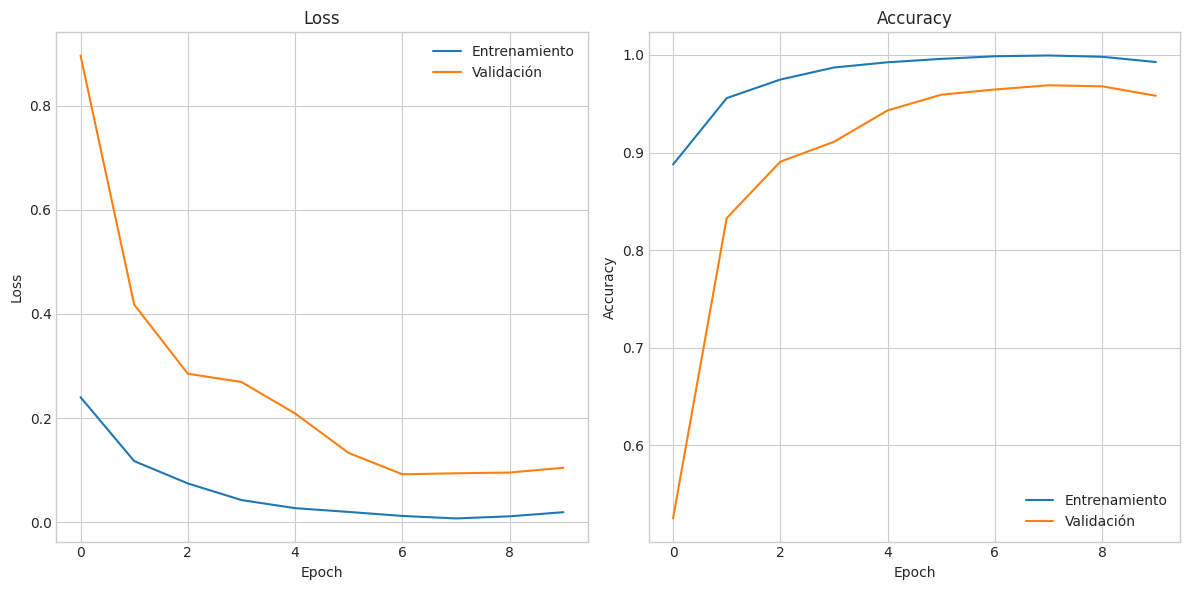

In [ ]:

def visualizar_resultados(history):
    """
    Visualiza las métricas de entrenamiento.
    """

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = [12, 6]
    

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

visualizar_resultados(history)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


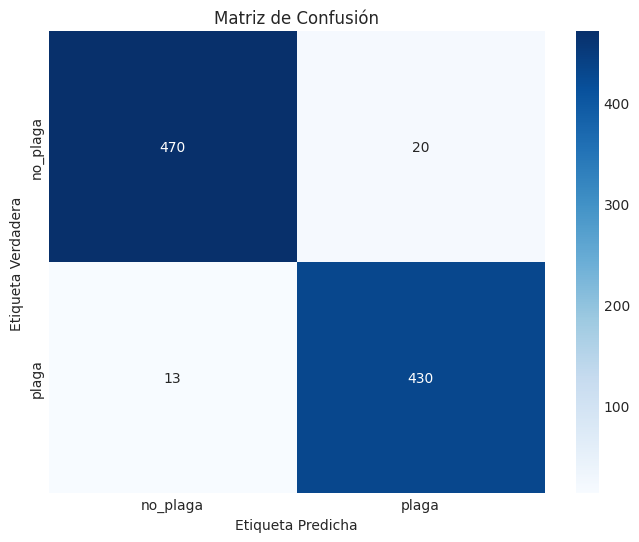

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = modelo.predict(X_val)
y_pred = (y_pred_probs >= 0.5).astype('int32')
y_true = y_val

cm = confusion_matrix(y_true, y_pred)

class_names = ['no_plaga', 'plaga']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/tmp/ipykernel_2338/277037566.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = int(pred_probs >= 0.5)  # Convertir a entero


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


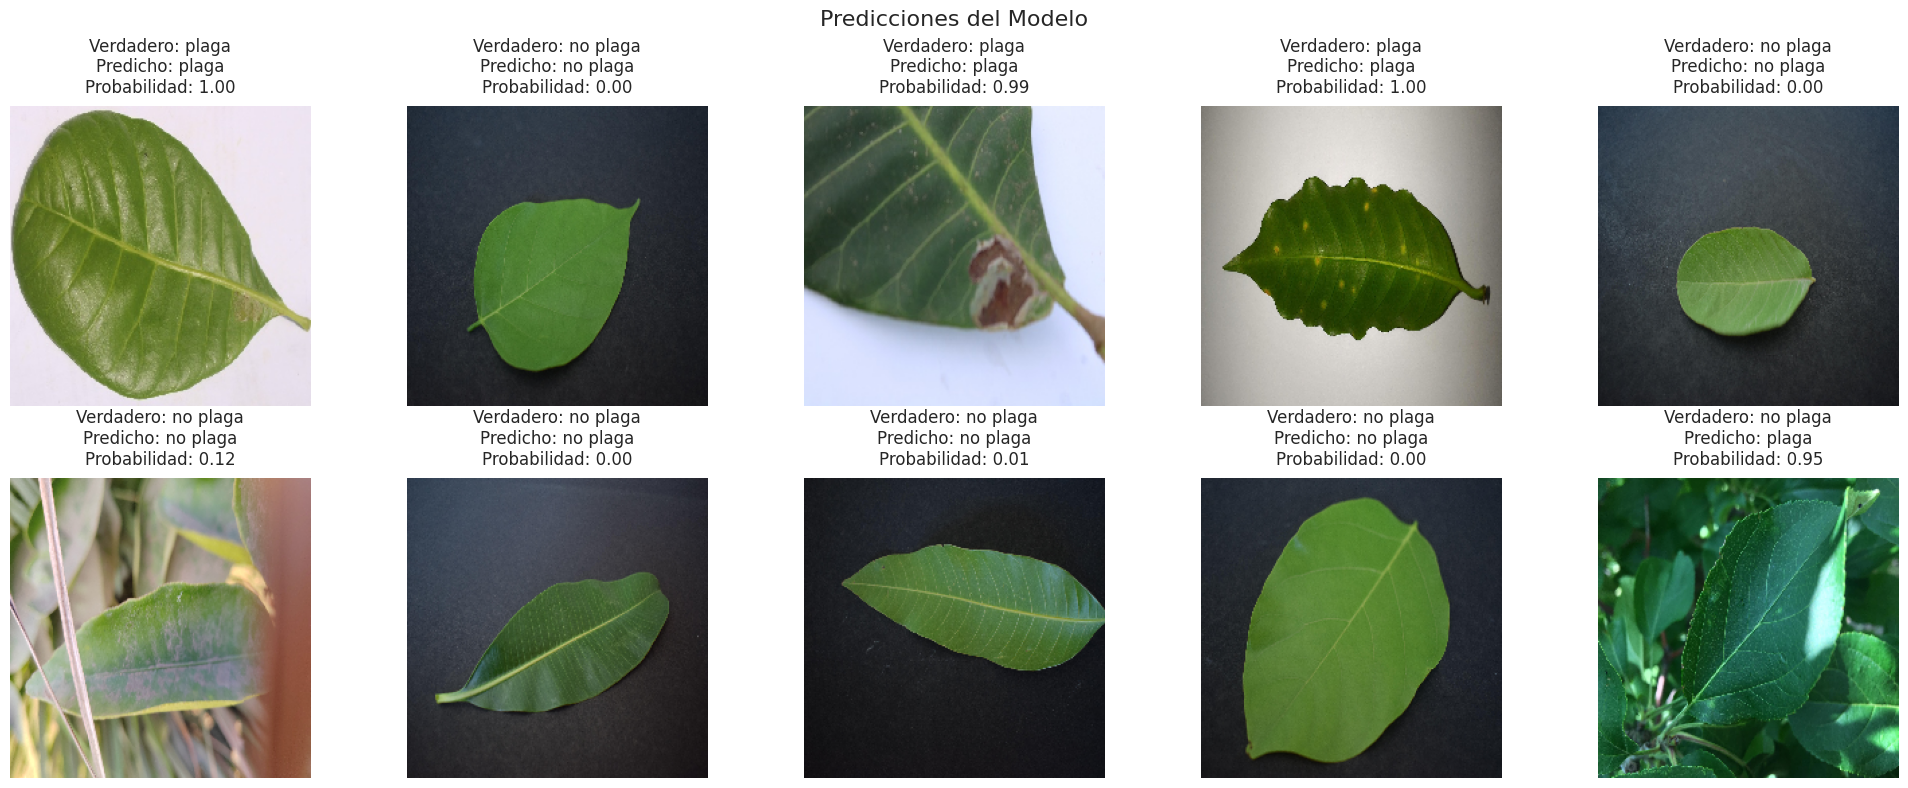

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def visualizar_predicciones_binarias(X_val, y_val, modelo, class_names=['no plaga', 'plaga']):
    """
    Visualiza predicciones aleatorias del conjunto de validación.
    """

    indices = random.sample(range(len(X_val)), 10)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle('Predicciones del Modelo', fontsize=16)

    for i, idx in enumerate(indices):
        img = X_val[idx]
        true_label = int(y_val[idx])  
        pred_probs = modelo.predict(np.expand_dims(img, axis=0))
        pred_label = int(pred_probs >= 0.5) 

        prob_pos = pred_probs[0][1] if pred_probs.shape[1] > 1 else pred_probs[0][0]
  
        ax = axes[i // 5, i % 5]
 
        ax.imshow(img)
        ax.axis('off')

        title = (
            f"Verdadero: {class_names[true_label]}\n"
            f"Predicho: {class_names[pred_label]}\n"
            f"Probabilidad: {prob_pos:.2f}"
        )
        ax.set_title(title, pad=10)
    
    plt.tight_layout()
    plt.show()

visualizar_predicciones_binarias(X_val, y_val, modelo)

In [29]:
modelo.save("modelo_plagas_binario.h5")